# pset 05: a mixture of five

# 1. reproduce Wiggins' k-means result

In [3]:
# parsing and visualization code taken from pset files

import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy import stats
from scipy.stats import nbinom
from scipy.special import logsumexp

infile = sys.argv[1]
outfig = sys.argv[2]

def read_data(infile):
    ctype = []
    data  = []
    with open(infile) as f:
        for line in f:
            if line[0] == '#': continue   # skip comment lines
            fields = line.split()
            ctype.append(int(fields[1]))
            data.append( [int(fields[2]), int(fields[3])])  # assumes exactly 2 genes!!
    ctype = np.array(ctype)
    data  = np.array(data)
    N, G  = np.shape(data)
    Q     = np.max(ctype) + 1
    return ctype, data, N, G, Q


def visualize_data(data, mu, C):
    N, G  = np.shape(data)
    Q, G2 = np.shape(mu)
    assert G == G2
    assert len(C) == N

    # We can assign colors to up to Q=10 components. If you want more, add more.
    colormap = ['xkcd:orange', 'xkcd:olive',     'xkcd:azure',    'xkcd:rose', 'xkcd:mustard', 
                'xkcd:peach',  'xkcd:turquoise', 'xkcd:lavender', 'xkcd:rust', 'xkcd:red']

    fig, ax = plt.subplots()
    for i in range(N):
        edgecolor = colormap[ C[i]]
        fillcolor = 'w'
        shape     = 'o'
        ax.loglog( data[i,0], data[i,1], marker=shape, mec=edgecolor, mfc=fillcolor, mew=1.5)

    for q in range(Q):
        ax.loglog(mu[q,0], mu[q,1], '*k', ms=10)

    ax.set_xlabel('caraway (counts)')
    ax.set_ylabel('kiwi (counts)')


ctype, data, N, G, Q = read_data('w05-data.tbl.txt')

In [4]:
# hard k-means

# initialization function - generates 5 random data points for the initial means
def initialize(lst, num_clusters):
    n = len(lst)
    index = np.random.randint(0, n, num_clusters)
    means = []
    for i in index:
        means.append(list(lst[i]))
    return means

# function for the assign step
def hard_assign(data, means):
    new_data = []
    
    # iterate through the data points
    for point in data:
        dist = []
        
        # iterate through the means, find distance of data point to each mean and add to list
        for mean in means:
            d = np.sqrt((point[0]-mean[0])**2 + (point[1]-mean[1])**2)
            dist.append(d)
        
        # find the minimum index of these distances 
        min_i = np.argmin(dist)
        
        # add that index as a third column in new data table, this is the cluster assignment
        point = np.array([point[0], point[1], min_i])
        new_data.append(point)
    return np.array(new_data)

# function for the update step
def hard_update(data):
    means = []
    
    # iterate through the cluster indices
    for i in range(5):
        
        # filter only the data points assigned to that cluster
        subset = data[data[:, 2] == i]
        
        # if no data points in a cluster, assign random point to empty cluster
        if len(subset) == 0:
            idx = np.random.randint(0,len(data))
            means.append(list(data[idx]))
        
        # otherwise calculate the new means by taking an average of each coordinate
        else:
            x = round(sum(subset[:,0])/len(subset),3)
            y = round(sum(subset[:,1])/len(subset),3)
            means.append([x, y])
    return means   


# function for running hard k-means
def hard_kmeans(data, num_clusters):
    means = []
    new_means = initialize(data, num_clusters)
    
    # continue running k-means until the means do not change in the update step
    while new_means != means:
        data = hard_assign(data, new_means)
        means = new_means
        new_means = hard_update(data)
    return (data, np.array(new_means))

In [5]:
# function for finding the total distance of points to their cluster means
def tot_sqdist(data, means):
    sqdist = 0
    for point in data:
        
        # find cluster assignment for each point and extract corresponding mean
        mean = means[int(point[2])]
        
        # calculate square distance and add to running total
        d = np.sqrt((point[0]-mean[0])**2 + (point[1]-mean[1])**2)
        sqdist += d
    return sqdist

In [6]:
# initilize sqdist to be large
sqdist = 1000000

# iterate 20 times, if new sqdist is smaller than old sqdist, take the new clustering as the best clustering
for i in range(10):
    (class_data, means) = hard_kmeans(data, 5)
    if tot_sqdist(class_data, means) < sqdist:
        sqdist = tot_sqdist(class_data, means)
        print(sqdist)
        best_data = class_data
        best_means = means

456377.4394891103
456170.71361759474


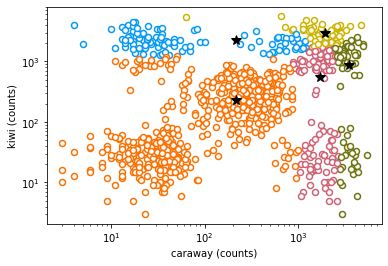

In [7]:
# our plot looks just as bad as wiggins' !
visualize_data(best_data[:,0:2], best_means, best_data[:,2])

While the five clusters are very obvious to us, this is because we have visualized the data in a graph with axes 10^x and 10^y. If we plotted the data on a normally scaled set of axes, we would have a very different distribution. Thus when the k-means algorithm runs on the data, it is not able to identify good clusters because the distances between points get exponentially scaled as you move up the axes (this is also why we have one very large cluster of points with counts less than 10^3).

# 2. mixture negative binomial fitting

In [7]:
# expectation step

def mixture_assign(data, means, pi, disp):
    new_clusters = []
    LL = 0
    
    # iterate through data indices
    for j in range(len(data)):
        prob_c = []
        point = data[j]
        
        # iterate through cluster indices
        for k in range(len(means)):
            mean = means[k]
            
            # use nbinom dist for each of x & y coordinates separately
            prob_g1 = nbinom.logpmf(point[0], 1/disp, 1/(1 + mean[0]*disp))
            prob_g2 = nbinom.logpmf(point[1], 1/disp, 1/(1 + mean[1]*disp))
            
            # calculate posterior probability in log space (add indiv gene probabilities with probability of the cluster)
            prob_c.append(pi[k] + prob_g1 + prob_g2)
        
        # add logsum of posterior probabilities to log likelihood parameter
        LL += logsumexp(prob_c)
        
        # normalize list of posterior probabilities using logsum, add to list of clusters
        prob_c[:] = [p - logsumexp(prob_c) for p in prob_c]
        new_clusters.append(prob_c)
        
    return (np.array(new_clusters), LL)

In [8]:
# maximization step

def mixture_update(data, means, clusters):
    new_means = []
    pi = []
    
    # iterate through cluster indices
    for i in range(len(means)):
        prob = 0
    
        # extract posterior probabilities for specific cluster and take logsum
        cluster_i = clusters[:,i]
        prob = logsumexp(cluster_i)
        
        # divide (subtract in log space) # of data points to get new cluster probability
        pi_c = prob - np.log(len(data))
        pi.append(pi_c)
        
        # generate lists of weighted data points to calculate new means
        xmean_lst = [cluster_i[j] + np.log(data[j][0]) for j in range(len(cluster_i))]
        ymean_lst = [cluster_i[j] + np.log(data[j][1]) for j in range(len(cluster_i))]
        
        # take logsum and normalize over logsum of posterior probabilities, exponentiate at the end to find new mean coords
        new_x_mean = np.exp(logsumexp(xmean_lst) - prob)
        new_y_mean = np.exp(logsumexp(ymean_lst) - prob)
        new_means.append([new_x_mean, new_y_mean])
        
    return (new_means, pi) 

In [31]:
# function to implement soft k-means algorithm
def soft_kmeans_algo(data, disp, threshold, num_clusters):
    
    # initilize means (using function from above, select 5 random data points), 
    # initialize pi (randomly selected values) & log likelihood
    means = initialize(data, num_clusters)
    pi = np.random.rand(num_clusters)
    pi = np.divide(pi,sum(pi))
    LL_old = -10000
    LL_new = 0
    
    # continue running k-means until the log likelihood parameters change by less than threshold value
    while abs(LL_new - LL_old) > threshold:
        LL_old = LL_new
        (clusters, LL_new) = mixture_assign(data, means, pi, disp)
        (means, pi) = mixture_update(data, means, clusters)
    return (means, clusters, LL_new)

# function to classify each data point to a cluster based on maximum posterior probability
def classify(clusters):
    plot_clusters = []
    for point in clusters:
        probs = []
        for i in range(0, len(point)):
             probs.append(np.exp(point[i]))
        plot_clusters.append(np.argmax(probs))
    return plot_clusters

In [29]:
def run_soft_kmeans(data, num_clusters, num_runs):
    # initilize log likelihood to be very small
    LL = float('-inf')

    # run soft k-means multiple times, select clustering with maximum log likelihood
    for i in range(num_runs):
        (means, clusters, LL_new) = soft_kmeans_algo(data, 0.3, .5, num_clusters)
        print('run', i+1, 'done')
        if LL_new > LL:
            print(LL_new)
            LL = LL_new
            best_soft_means = means
            best_soft_clusters = clusters
            
    # properly clustered !
    soft_clusters = np.array(classify(best_soft_clusters))
    soft_means = np.array(best_soft_means)
    visualize_data(data, soft_means, soft_clusters)

run 1 done
-15468.633304812387
run 2 done
-14008.843714927056
run 3 done
run 4 done
-14008.843377131514
run 5 done


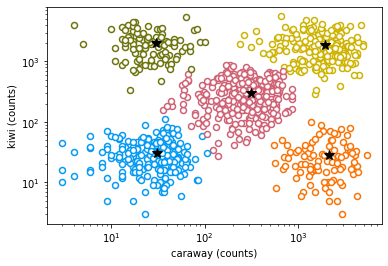

In [30]:
run_soft_kmeans(data, 5, 5)

# 3. find a simple fix for k-means

Looking at our initial visualization, we can see that it might help if we were able to similarly scale down the distances between data points for the k-means algorithm. Thus, we can try clustering on the log of our data instead!

In [13]:
# we can cluster the log of the data !
log_data = np.log(data)

In [14]:
# run multiple iterations and select best one
# these sqdist values look a lot more promising...

sqdist = 1000000
for i in range(0, 20):
    (class_data, means) = hard_kmeans(log_data)
    if tot_sqdist(class_data, means) < sqdist:
        sqdist = tot_sqdist(class_data, means)
        print(sqdist)
        best_data = class_data
        best_means = means

737.4174707067372


In [15]:
clusters = np.array([int(x) for x in best_data[:,2]])
means = np.exp(best_means)

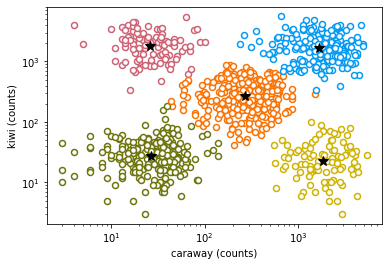

In [16]:
# this looks just like our mixture negative binomial fitting !
visualize_data(data, means, clusters)